<a href="https://colab.research.google.com/github/claredavies/ImageAnalysisAssignment/blob/main/ImageAnalysisAssignment1BeachPeopleCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 5.3 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [3]:
from imutils.object_detection import non_max_suppression
import cv2
import numpy as np
import imutils 
import dlib
from google.colab import files
import io
import pandas as pd
import os
from os import listdir
import glob
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.metrics import mean_squared_error 
from skimage.metrics import structural_similarity as compare_ssim
import time
import tracemalloc

In [4]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


# Read in files

In [5]:
!git clone https://github.com/claredavies/ImageAnalysisAssignment.git

Cloning into 'ImageAnalysisAssignment'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 159 (delta 21), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (159/159), 279.58 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [6]:
%cd ImageAnalysisAssignment/Assignment1Data

/content/ImageAnalysisAssignment/Assignment1Data


Read in labels

In [7]:
labels = pd.read_csv('Labels/people-labels.csv')
labels.head(3)

,Label,X,Y,Filename,Width,Height
0,Person,263,588,1660194000.jpg,1920,1080
1,Person,293,580,1660194000.jpg,1920,1080
2,Person,318,578,1660194000.jpg,1920,1080


Read in images

In [8]:
# get the path/directory
folder_dir = "images"
for images in os.listdir(folder_dir):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
        print(images)

1660204800.jpg
1660226400.jpg
1660197600.jpg
1660194000.jpg
1660215600.jpg
1660222800.jpg
1660208400.jpg
1660212000.jpg
1660201200.jpg
1660219200.jpg


Algorithm design and implementation to i) identify every person and ii) count the number of
people in every photograph.

# Pre-processing functions

In [9]:
def find_difference_images(currentImage, previousImage):
  result = np.zeros(currentImage.shape[0:2])

  if currentImage.ndim == 3:
    currentImage = cv2.cvtColor(currentImage, cv2.COLOR_BGR2GRAY)

  if previousImage.ndim == 3:
    previousImage = cv2.cvtColor(previousImage, cv2.COLOR_BGR2GRAY)

  h = currentImage.shape[0]
  w = previousImage.shape[1]

  # is 255 (white) or 0 (black)
  # loop over the image, pixel by pixel
  for y in range(0, h):
      for x in range(0, w):
          # threshold the pixel
          if(currentImage[y][x] == 0 and previousImage[y][x] == 255):
            result[y, x] = 255
  result = cv2.convertScaleAbs(result)
  return result

In [10]:
def preprocess(frame):
  # convert to gray
  gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  # blur
  smooth = cv2.GaussianBlur(gray, (95,95), 0)

  # divide gray by morphology image
  division = cv2.divide(gray, smooth, scale=192)
  return division

# Background Substraction

In [11]:
def motionDetection(image_path_folder, labels, applyFilter, showImages):  
  list_image_name = []
  list_positions_head_found_x = []
  list_positions_head_found_y = []

  image_paths = glob.glob(image_path_folder)
  previous = cv2.imread("images/1660194000.jpg") 
  previous = preprocess(previous)

  for image_path in image_paths:
    image_name = image_path.split(os.path.sep)[-1]
    image = cv2.imread(image_path) 
    frame = image


    if applyFilter:
      frame = preprocess(frame)

    else:
      frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    # cv2_imshow(frame)

    (thresh, bw) = cv2.threshold(frame, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    frame =  bw

    # cv2_imshow(frame)
    # print("previous")
    # cv2_imshow(previous)
    # print("current")
    # cv2_imshow(frame)

    diff = find_difference_images(frame, previous)
    # print("difference")
    # cv2_imshow(diff)

    contours, hierarchy = cv2.findContours(diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # draw the contours, not strictly necessary
    # for i, cnt in enumerate(contours):
    #     cv2.drawContours(frame, contours, i, (0, 0, 255), 3)
    for contour in contours:
        # continue through the loop if contour area is less than 500...
        # ... helps in removing noise detection
        if cv2.contourArea(contour) < 500:
            continue
        # get the xmin, ymin, width, and height coordinates from the contours
        (x, y, w, h) = cv2.boundingRect(contour)
        center = (x+w//2, y+h//2)
        # draw the bounding boxes
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        if findIfMatchingLabelForPerson(labels, center, image_name) == True:
          cv2.circle(image, center, 3, (255, 0, 0 ), 4)
    
        list_image_name.append(image_name)
        list_positions_head_found_x.append(center[0])
        list_positions_head_found_y.append(center[1])

    if showImages:
      cv2_imshow(image)

    previous = frame

  df_image_head_pos= pd.DataFrame(
      {"Filename": list_image_name, "X": list_positions_head_found_x, "Y": list_positions_head_found_y}
  )
  df_image_head_pos.drop_duplicates()

  return df_image_head_pos

# Haar Cascade

In [12]:
def detectHaarcascadeImage(img, haarcascade, image_name, applyFilter, showImages):
  list_points_found_per_image = []

  if applyFilter:
    if(len(img.shape) ==3):
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)

  haarcascade_found = haarcascade.detectMultiScale(img, scaleFactor=1.05,minNeighbors=5)
  for (x,y,w,h) in haarcascade_found:
    center = (x+w//2, y+h//2)
    if findIfMatchingLabelForPerson(labels, center, image_name) == True:
      cv2.circle(img, center, 3, (255, 0, 0 ), 4)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    list_points_found_per_image.append(center)
      # haarcascade_outer_foundROI = img_gray[y:y+h,x:x+w]
  if showImages:
    cv2_imshow(img)
  return list_points_found_per_image

In [13]:
def HaarcascadeImageFolder(image_path_folder, applyFilter, showImages):
  list_image_name = []
  list_positions_head_found_x = []
  list_positions_head_found_y = []
  image_paths = glob.glob(image_path_folder)

  full_body_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades + "haarcascade_fullbody.xml"))
  for image_path in image_paths:
    image_name = image_path.split(os.path.sep)[-1]
    image = cv2.imread(image_path)
    list_points_found_per_image = detectHaarcascadeImage(image, full_body_cascade, image_name, applyFilter, showImages)  

    for x in list_points_found_per_image:
      list_image_name.append(image_name)
      list_positions_head_found_x.append(x[0])
      list_positions_head_found_y.append(x[1])

  df_image_head_pos= pd.DataFrame(
      {"Filename": list_image_name, "X": list_positions_head_found_x, "Y": list_positions_head_found_y}
  )
  df_image_head_pos.drop_duplicates()
  return df_image_head_pos

# HOG

In [14]:
def HOGImage(image, image_name, applyFilter, showImages):
  scaleFactor = 2
  minNeighbors = 1

  list_points_found_per_image = []

  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

  if image.shape[1] < 400: # if image width < 400
      (height, width) = image.shape[:2]
      ratio = width / float(width) # find the width to height ratio
      image = cv2.resize(image, (400, width*ratio)) # resize the image according to the width to height ratio

  if applyFilter:
  # keep a minimum image size for accurate predictions
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  rects, weights = hog.detectMultiScale(image, winStride=(2, 2), padding=(10, 10), scale=0.5)
  for i, (x, y, w, h) in enumerate(rects):
    center = (x+w//2, y+h//2)
    if weights[i] < 0.13:
      continue
    elif weights[i] < 0.3 and weights[i] > 0.13:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
      if findIfMatchingLabelForPerson(labels, center, image_name) == True:
          cv2.circle(image, center, 3, (255, 0, 0 ), 4)
      list_points_found_per_image.append(center)
    if weights[i] < 0.7 and weights[i] > 0.3:
      cv2.rectangle(image, (x, y), (x+w, y+h), (50, 122, 255), 2)
      if findIfMatchingLabelForPerson(labels, center, image_name) == True:
          cv2.circle(image, center, 3, (255, 0, 0 ), 4)
      list_points_found_per_image.append(center)
    if weights[i] > 0.7:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
      if findIfMatchingLabelForPerson(labels, center, image_name) == True:
          cv2.circle(image, center, 3, (255, 0, 0 ), 4)
      list_points_found_per_image.append(center)

  if showImages:
    cv2_imshow(image)

  return list_points_found_per_image

In [15]:
def HOGImageFolder(image_path_folder, applyFilter, showImages):
  list_image_name = []
  list_positions_head_found_x = []
  list_positions_head_found_y = []
  image_paths = glob.glob(image_path_folder)
  for image_path in image_paths:
    image_name = image_path.split(os.path.sep)[-1]
    image = cv2.imread(image_path)
    list_points_found_per_image = HOGImage(image, image_name, applyFilter, showImages)  

    for x in list_points_found_per_image:
      list_image_name.append(image_name)
      list_positions_head_found_x.append(x[0])
      list_positions_head_found_y.append(x[1])

    

  df_image_head_pos= pd.DataFrame(
      {"Filename": list_image_name, "X": list_positions_head_found_x, "Y": list_positions_head_found_y}
  )
  df_image_head_pos.drop_duplicates()
  return df_image_head_pos

# Mean Squared Error Functions

In [16]:
def removeFalsePositives(labels, dfPeopleFound):
  labels['FoundX'] = 0
  labels['FoundY'] = 0

  threshold_cutoff = 30
  for indexOuter, rowOuter in labels.iterrows():
    for indexInner, rowInner in dfPeopleFound.iterrows():
      if rowOuter['Filename'] ==  rowInner['Filename']:
        if abs(rowOuter['X']- rowInner['X']) < threshold_cutoff:
          if abs(rowOuter['Y']- rowInner['Y']) < threshold_cutoff:
            # print("Found:  x:" + str(rowInner['X']) + "  y:" + str(rowInner['Y']))
            # print("Actual:  x:" + str(rowOuter['X']) + "  y:" + str(rowOuter['Y']))
            labels.at[indexOuter,'FoundX'] = rowInner['X']
            labels.at[indexOuter,'FoundY'] = rowInner['Y']
  
  return labels

In [17]:
def findMeanSquaredError(labels, dfPeopleFound):
  labels = removeFalsePositives(labels, dfPeopleFound)

  subset = labels[(labels["FoundX"] != 0) | (labels["FoundY"] != 0)]

  mseX = None
  mseY = None

  if subset.empty:
    print('Not matches after matching to original labels')

  else:  
    mseY = mean_squared_error(subset.Y, subset.FoundY)
    mseX = mean_squared_error(subset.X, subset.FoundX)

  return [mseX, mseY]

# Evaluation - Person-level Function

In [18]:
def generateDfFoundBasedOnIfMatchingLabel(labels, dfFound):
  dfR = dfFound.copy()
  dfR["MatchFound"] = None

  for row in dfR.itertuples():

    if(findIfMatchingLabelForPerson(labels, (row.X,row.Y), row.Filename) == True):
      dfR.loc[row.Index,"MatchFound"] = "True"

    elif(findIfMatchingLabelForPerson(labels, (row.X,row.Y), row.Filename) == False):
      dfR.loc[row.Index, "MatchFound"] = "False"

  # labelsPerFile = labels.groupby(['Filename'])['Filename'].count()
  # totalNumPeople = len(labels)  
  # print("total number of person labels: " + str(totalNumPeople))

  # list_image_name = []
  # list_actual_number_heads = []
  # for image_name, total_people_per_image in labelsPerFile.items():
  #   list_image_name.append(image_name)
  #   list_actual_number_heads.append(total_people_per_image)

  # df_persons_found_versus_actual = pd.DataFrame( {"Filename": list_image_name, "Actual": list_actual_number_heads})
  # df_persons_found_versus_actual["Found"] = 0

  # peopleFoundPerFile = dfFound.groupby(['Filename'])['Filename'].count()
  # for image_name, total_people_per_image in peopleFoundPerFile.items():
  #   df_persons_found_versus_actual.loc[df_persons_found_versus_actual["Filename"] == image_name, "Found"] = total_people_per_image

  # print(df_persons_found_versus_actual)

  return dfR

In [19]:
def plotPersonFound(df):
  df.plot(x='Filename', y=['Actual','Found'], kind='bar') 
  plt.show()

Method checking if found point 

In [20]:
def findIfMatchingLabelForPerson(labels, position, imageName):
  for index, row in labels.iterrows():
    threshold = 30
    if row['Filename'] == imageName:
      if abs(row['X'] - position[0]) < threshold and abs(row['Y'] - position[1]) < threshold:
        return True
  return False

# Timing Evaluation

In [21]:
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())

In [22]:
def createHTMLOfDf(df, name):
  html = df.to_html()
  
  # write html to file
  text_file = open(name, "w")
  text_file.write(html)
  text_file.close()

# Execution

In [23]:
image_path = 'images/*.jpg'

HOG - no filter

In [24]:
tracing_start()
start = time.time()
dfHogFound = HOGImageFolder(image_path, False, False)
end = time.time()
HogTime = (end-start)*1000
print("time elapsed HOG {} milli seconds".format(HogTime))
meanSquaredErrorHog = findMeanSquaredError(labels.copy(), dfHogFound)
print("mean sqaured error x: " + str(meanSquaredErrorHog[0]))
print("mean sqaured error y: " + str(meanSquaredErrorHog[1]))
dfPersonLevelResultsHog = generateDfFoundBasedOnIfMatchingLabel(labels.copy(), dfHogFound)

nTracing Status :  False
Tracing Status :  True
time elapsed HOG 24123.812675476074 milli seconds
mean sqaured error x: 22.38888888888889
mean sqaured error y: 115.38888888888889


Hog - filter

In [25]:
tracing_start()
start = time.time()
dfHogFoundFilter = HOGImageFolder(image_path, True, False)
end = time.time()
HogTimeFilter = (end-start)*1000
print("time elapsed HOG Filter {} milli seconds".format(HogTimeFilter))
meanSquaredErrorHogFilter = findMeanSquaredError(labels.copy(), dfHogFoundFilter)
print("mean sqaured error x: " + str(meanSquaredErrorHogFilter[0]))
print("mean sqaured error y: " + str(meanSquaredErrorHogFilter[1]))
dfPersonLevelResultsHogFilter = generateDfFoundBasedOnIfMatchingLabel(labels.copy(), dfHogFoundFilter)

nTracing Status :  False
Tracing Status :  True
time elapsed HOG Filter 23886.28077507019 milli seconds
mean sqaured error x: 21.863636363636363
mean sqaured error y: 156.36363636363637


Haar - no filter

In [26]:
tracing_start()
start = time.time()
dfHaarFound = HaarcascadeImageFolder(image_path, False, False)
end = time.time()
Haartime = (end-start)*1000
print("time elapsed Haar {} milli seconds".format(Haartime))
meanSquaredErrorHaar = findMeanSquaredError(labels.copy(), dfHaarFound)
print("mean sqaured error x: " + str(meanSquaredErrorHaar[0]))
print("mean sqaured error y: " + str(meanSquaredErrorHaar[1]))
dfPersonLevelResultsHaar = generateDfFoundBasedOnIfMatchingLabel(labels.copy(), dfHaarFound)

nTracing Status :  False
Tracing Status :  True
time elapsed Haar 19096.357107162476 milli seconds
mean sqaured error x: 222.1818181818182
mean sqaured error y: 108.81818181818181


Haar - filter

In [27]:
tracing_start()
start = time.time()
dfHaarFoundFilter = HaarcascadeImageFolder(image_path, True, False)
end = time.time()
HaarFilterTime = (end-start)*1000
print("time elapsed Haar {} milli seconds".format(HaarFilterTime))
meanSquaredErrorHaarFilter = findMeanSquaredError(labels.copy(), dfHaarFoundFilter)
print("mean sqaured error x: " + str(meanSquaredErrorHaarFilter[0]))
print("mean sqaured error y: " + str(meanSquaredErrorHaarFilter[1]))
dfPersonLevelResultsHaarFilter = generateDfFoundBasedOnIfMatchingLabel(labels.copy(), dfHaarFoundFilter)

nTracing Status :  False
Tracing Status :  True
time elapsed Haar 23410.150051116943 milli seconds
mean sqaured error x: 133.07692307692307
mean sqaured error y: 60.15384615384615


Motion Detection

In [28]:
tracing_start()
start = time.time()
dfMotionFound = motionDetection(image_path, labels.copy(), False, False)
end = time.time()
MotionTime = (end-start)*1000
print("time elapsed Motion {} milli seconds".format(MotionTime))
meanSquaredErrorMotion = findMeanSquaredError(labels.copy(), dfMotionFound)
print("mean sqaured error x: " + str(meanSquaredErrorMotion[0]))
print("mean sqaured error y: " + str(meanSquaredErrorMotion[1]))
dfPersonLevelResultsMotion = generateDfFoundBasedOnIfMatchingLabel(labels.copy(), dfMotionFound)

nTracing Status :  False
Tracing Status :  True
time elapsed Motion 120661.71383857727 milli seconds
mean sqaured error x: 162.0625
mean sqaured error y: 163.4375


Motion Detection - filter

In [29]:
tracing_start()
start = time.time()
dfMotionFoundFilter = motionDetection(image_path, labels.copy(), True, False)
end = time.time()
MotionTimeFilter = (end-start)*1000
print("time elapsed Motion {} milli seconds".format(MotionTimeFilter))
meanSquaredErrorMotionFilter = findMeanSquaredError(labels.copy(), dfMotionFoundFilter)
print("mean sqaured error x: " + str(meanSquaredErrorMotionFilter[0]))
print("mean sqaured error y: " + str(meanSquaredErrorMotionFilter[1]))
dfPersonLevelResultsMotionFilter = generateDfFoundBasedOnIfMatchingLabel(labels.copy(), dfMotionFoundFilter)

nTracing Status :  False
Tracing Status :  True
time elapsed Motion 93027.08840370178 milli seconds
mean sqaured error x: 115.91666666666667
mean sqaured error y: 133.625


# Evaluation Overall

In [30]:
def formEvaluationDf(labels, dfEval, alogorithmName,meanSquaredErrorXY, dfResultsPersonFound, timeTakenMs):
  noLabel = len(labels.index)
  noResultsFound = len(dfResultsPersonFound.index)

  if noResultsFound > 0:
    matchPerFile = dfResultsPersonFound.groupby(['MatchFound'])['MatchFound'].count()
    foundNegativeMatch = matchPerFile[0]
    foundPositiveMatch = matchPerFile[1]
    percentageFoundMatchLabel = (foundPositiveMatch/noLabel)*100
    percentageFalsePositive = (foundNegativeMatch/(foundPositiveMatch + foundNegativeMatch))*100
    dfEvaluation = dfEval.append({'AlgorithmName': alogorithmName,'FoundMatchLabelPercentage': percentageFoundMatchLabel, 'FoundFalsePositivePercentage': percentageFalsePositive, 'MeanSquaredX': meanSquaredErrorXY[0], 'MeanSquaredY': meanSquaredErrorXY[1], 'TimeTakenMs': timeTakenMs}, ignore_index=True)
  
  else:
    dfEvaluation = dfEval.append({'AlgorithmName': alogorithmName,'FoundMatchLabelPercentage': None, 'FoundFalsePositivePercentage': None, 'MeanSquaredX': None, 'MeanSquaredY': None, 'TimeTakenMs': timeTakenMs}, ignore_index=True)
  
  return dfEvaluation

In [31]:
dfEvaluation = pd.DataFrame(columns=['AlgorithmName', 'FoundMatchLabelPercentage', 'FoundFalsePositivePercentage', 'MeanSquaredX','MeanSquaredY','TimeTakenMs'])
dfEvaluation = formEvaluationDf(labels.copy(), dfEvaluation, 'Hog', meanSquaredErrorHog, dfPersonLevelResultsHog, HogTime)
dfEvaluation = formEvaluationDf(labels.copy(), dfEvaluation, 'HogFilter', meanSquaredErrorHogFilter, dfPersonLevelResultsHogFilter, HogTimeFilter)
dfEvaluation = formEvaluationDf(labels.copy(), dfEvaluation, 'Haar', meanSquaredErrorHaar, dfPersonLevelResultsHaar, Haartime)
dfEvaluation = formEvaluationDf(labels.copy(), dfEvaluation, 'HaarFilter', meanSquaredErrorHaarFilter, dfPersonLevelResultsHaarFilter, HaarFilterTime)
dfEvaluation = formEvaluationDf(labels.copy(), dfEvaluation, 'Motion', meanSquaredErrorMotion, dfPersonLevelResultsMotion, MotionTime)
dfEvaluation = formEvaluationDf(labels.copy(), dfEvaluation, 'MotionFilter', meanSquaredErrorMotionFilter, dfPersonLevelResultsMotionFilter, MotionTimeFilter)

In [32]:
createHTMLOfDf(dfEvaluation, "dfEval.html")

In [33]:
!pwd

/content/ImageAnalysisAssignment/Assignment1Data


In [34]:
print(dfEvaluation.head(6))

  AlgorithmName  FoundMatchLabelPercentage  FoundFalsePositivePercentage  \
0           Hog                  33.333333                     62.500000   
1     HogFilter                  40.740741                     67.164179   
2          Haar                  14.814815                     65.217391   
3    HaarFilter                  20.370370                     54.166667   
4        Motion                  27.777778                     89.208633   
5  MotionFilter                  42.592593                     87.222222   

   MeanSquaredX  MeanSquaredY    TimeTakenMs  
0     22.388889    115.388889   24123.812675  
1     21.863636    156.363636   23886.280775  
2    222.181818    108.818182   19096.357107  
3    133.076923     60.153846   23410.150051  
4    162.062500    163.437500  120661.713839  
5    115.916667    133.625000   93027.088404  


# Evaluation Per Image

In [35]:
def formEvaluationDfPerImage(labels, alogorithmName, dfResultsPersonFound):
  dfEval= pd.DataFrame(columns=['Algorithm', 'Filename', 'TotalNumberLabelsInImage', '%LabelsFound', '%FalsePositives'])
  dfResultByImage = dfPersonLevelResultsMotion.groupby(['Filename'])['Filename'].count()

  for imageName, countFound in dfResultByImage.items():
    noLabelsForImage = labels[labels['Filename'] == imageName].count()[0]
    foundNegativeMatch = dfResultsPersonFound[(dfResultsPersonFound['Filename'] == imageName) & (dfResultsPersonFound['MatchFound'] == 'False')].count()[0]
    foundPositiveMatch = dfResultsPersonFound[(dfResultsPersonFound['Filename'] == imageName) & (dfResultsPersonFound['MatchFound'] == 'True')].count()[0]
    percentageFoundMatchLabelPerImage = (foundPositiveMatch/noLabelsForImage)*100
    percentageFalsePositivePerImage = (foundNegativeMatch/(foundPositiveMatch + foundPositiveMatch))*100
    dfEval = dfEval.append({'Algorithm': alogorithmName, 'Filename': imageName,'TotalNumberLabelsInImage': noLabelsForImage, '%LabelsFound': percentageFoundMatchLabelPerImage, '%FalsePositives': percentageFalsePositivePerImage}, ignore_index=True)

  return dfEval

In [36]:
dfEvaluationImageHog = formEvaluationDfPerImage(labels.copy(), 'Hog', dfPersonLevelResultsHog)
dfEvaluationImageHaar = formEvaluationDfPerImage(labels.copy(), 'Haar', dfPersonLevelResultsHaar)
dfEvaluationImageMotion = formEvaluationDfPerImage(labels.copy(),'Motion', dfPersonLevelResultsMotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [37]:
print(dfEvaluationImageMotion)

  Algorithm        Filename TotalNumberLabelsInImage  %LabelsFound  \
0    Motion  1660194000.jpg                        3      0.000000   
1    Motion  1660197600.jpg                        1      0.000000   
2    Motion  1660201200.jpg                       10     20.000000   
3    Motion  1660208400.jpg                        5     20.000000   
4    Motion  1660212000.jpg                        2     50.000000   
5    Motion  1660215600.jpg                        6      0.000000   
6    Motion  1660219200.jpg                        3      0.000000   
7    Motion  1660222800.jpg                        9     77.777778   
8    Motion  1660226400.jpg                        7     57.142857   

   %FalsePositives  
0              inf  
1              inf  
2       200.000000  
3       200.000000  
4       850.000000  
5              inf  
6              inf  
7        78.571429  
8       450.000000  


In [38]:
createHTMLOfDf(dfEvaluationImageMotion, "dfEvalImage.html")

# Individual Comparison

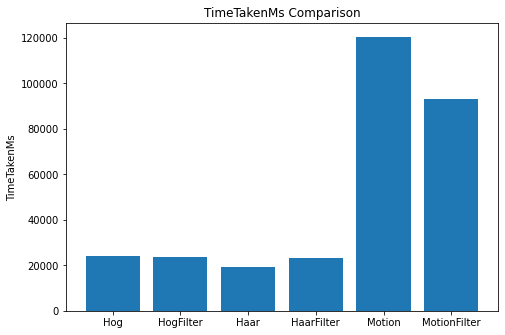

In [39]:
# Plot time
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = dfEvaluation.AlgorithmName
Y = dfEvaluation.TimeTakenMs
ax.bar(labels, Y)
plt.ylabel("TimeTakenMs")
plt.title("TimeTakenMs Comparison")
plt.show()

FoundMatchLabelPercentage

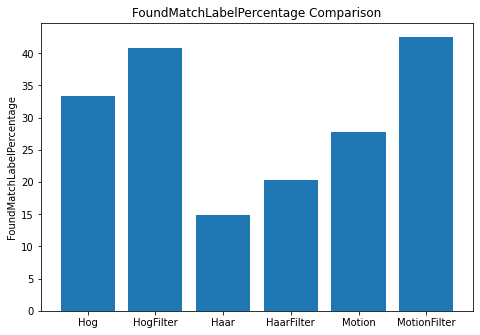

In [40]:
# Plot time
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = dfEvaluation.AlgorithmName
Y = dfEvaluation.FoundMatchLabelPercentage
ax.bar(labels, Y)
plt.ylabel("FoundMatchLabelPercentage")
plt.title("FoundMatchLabelPercentage Comparison")
plt.show()

FoundFalsePositivePercentage

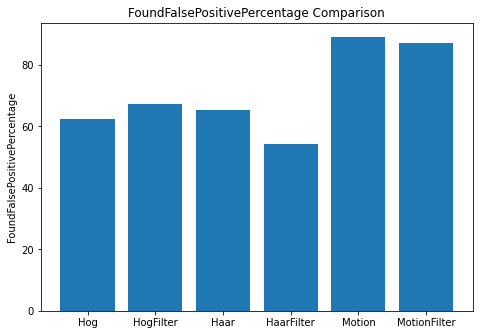

In [41]:
# Plot time
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = dfEvaluation.AlgorithmName
Y = dfEvaluation.FoundFalsePositivePercentage
ax.bar(labels, Y)
plt.ylabel("FoundFalsePositivePercentage")
plt.title("FoundFalsePositivePercentage Comparison")
plt.show()